In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_vae import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.utils import *
from esa.lstm_utils import *

import platform

import numpy as np

architecture = 'lstm_vae'

In [2]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_vae_sl_16_emb_32_layers_1_1_recon_loss_custom_22_03_2023_16:28:54.pth


In [3]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_vae_sl_16_emb_32_layers_1_1_recon_loss_custom_22_03_2023_16:28:54.pth


In [5]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [7]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model])
params_conf = checkpoint['param_conf']

In [8]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

In [10]:
data_path = params_conf['data_path']

In [12]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)  

In [ ]:
no_features=len(cfg.dataset.columns),
                        output_size=len(cfg.dataset.target), embedding_dim=cfg.model.embedding_dim, 
    latent_dim=cfg.model.latent_dim,
                         Nf_lognorm=cfg.model.Nf_lognorm, Nf_binomial=cfg.model.Nf_binomial,
                         n_layers_1=cfg.model.n_layers_1, n_layers_2=cfg.model.n_layers_2, 
            recon_loss_type=cfg.model.recon_loss,
                         kld_type=cfg.model.kld

In [26]:
model = LSTM_VAE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['n_features'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
        Nf_lognorm=params_conf['n_features'], Nf_binomial=0, n_layers_1=params_conf['n_layers_1'],
        n_layers_2=params_conf['n_layers_2'], 
        kld_type=params_conf['kld'], recon_loss_type=params_conf['recon_loss'])
    
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

LSTM_VAE(
  (encoder): Encoder_vae(
    (LSTMenc): LSTM(16, 64, batch_first=True)
    (LSTM1): LSTM(64, 32, batch_first=True)
    (mu): Linear(in_features=32, out_features=100, bias=True)
    (logvar): Linear(in_features=32, out_features=100, bias=True)
  )
  (decoder): Decoder_vae(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(100, 32, batch_first=True)
    (LSTM1): LSTM(32, 64, batch_first=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)
number of params 85496


In [17]:
compute_mse_val_loss = False

In [18]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [23]:
num_batch = 5
inject_anomalies = False

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 1592


In [24]:
x, mu, log_var, pars  = model(x.to(device))
yo = pars[0]

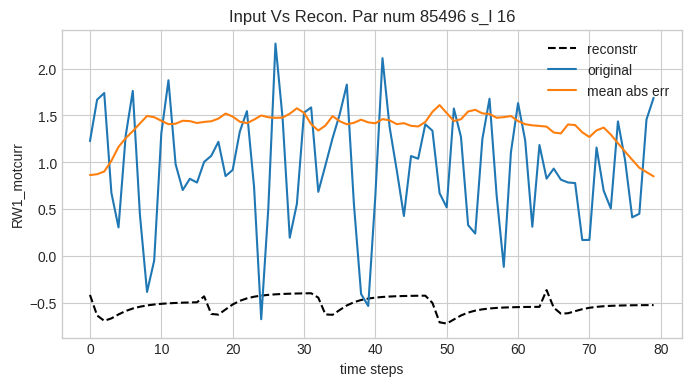

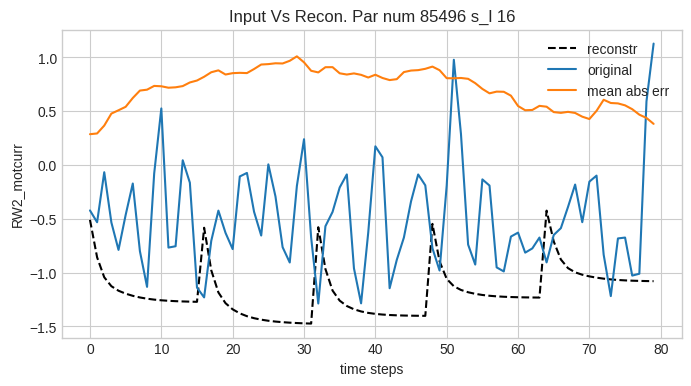

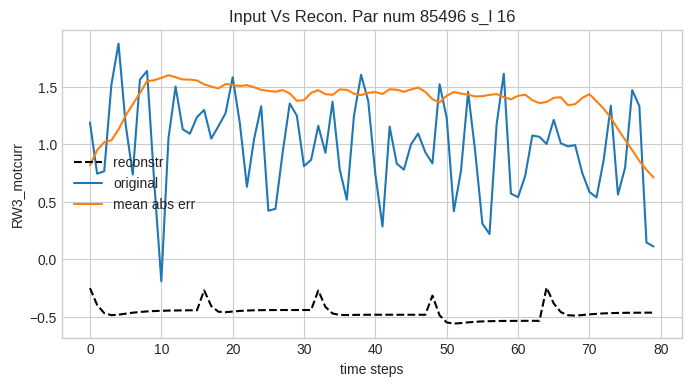

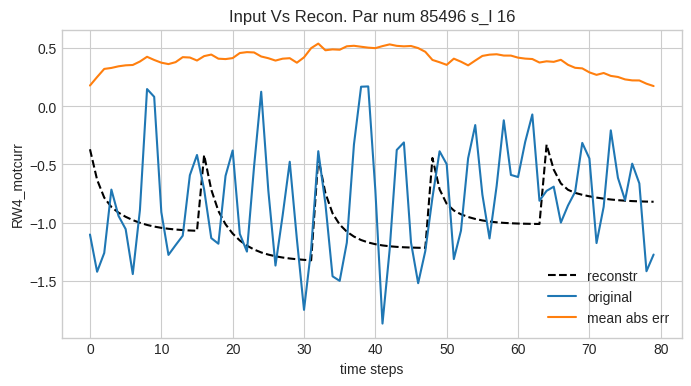

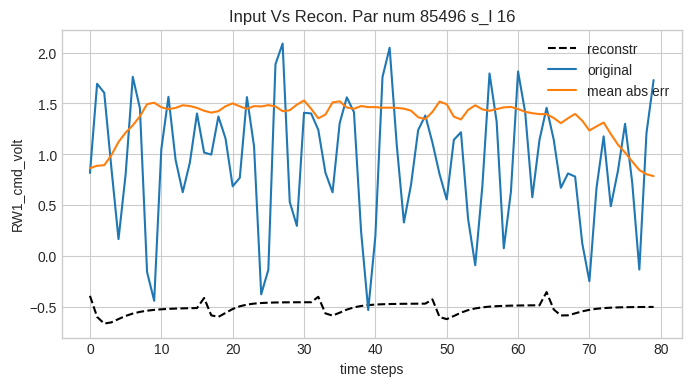

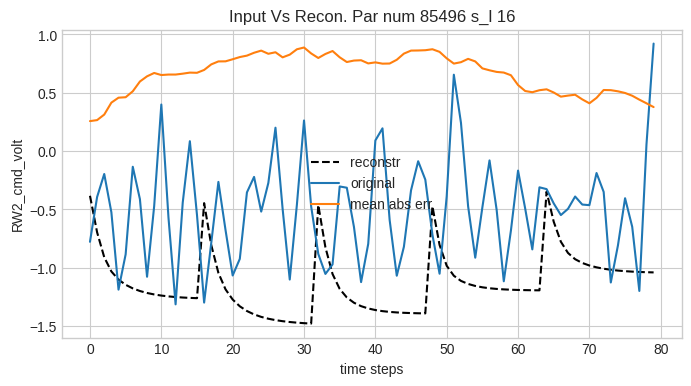

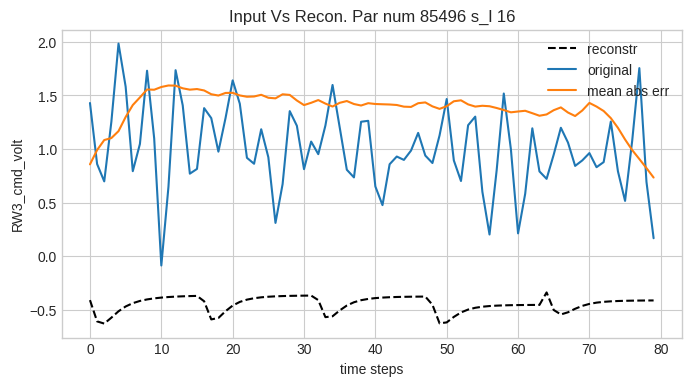

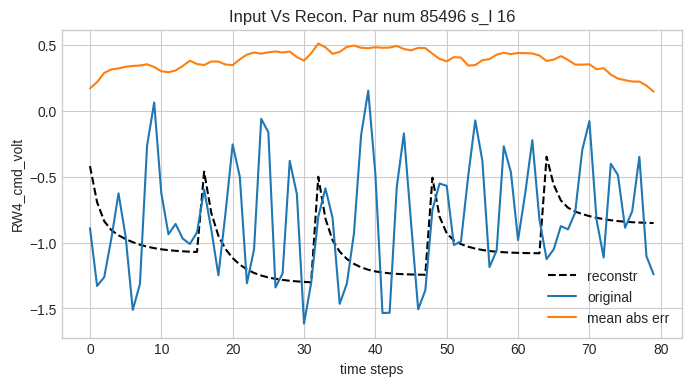

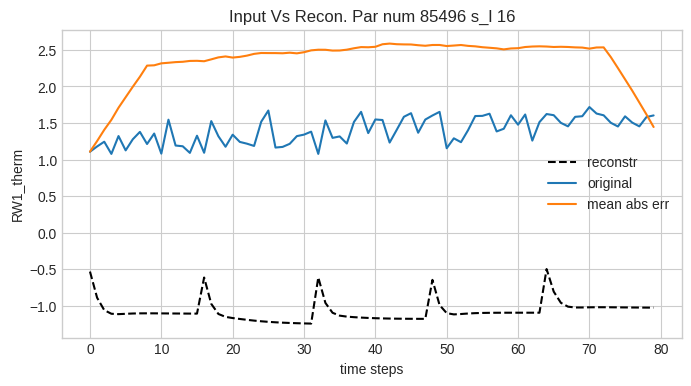

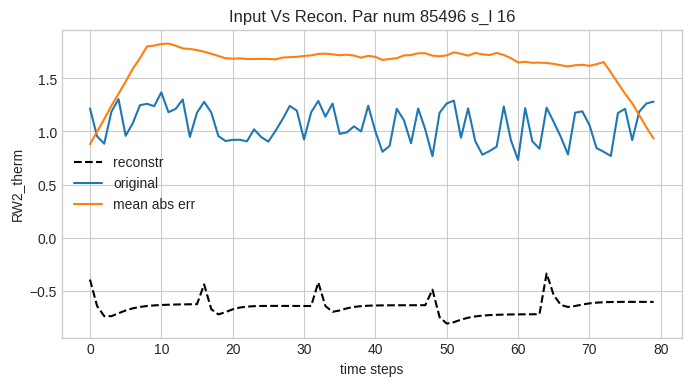

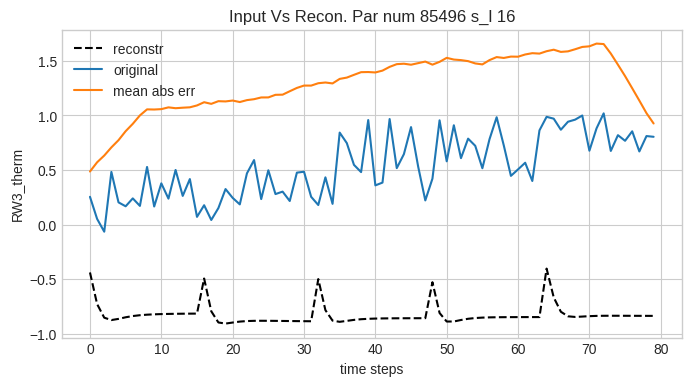

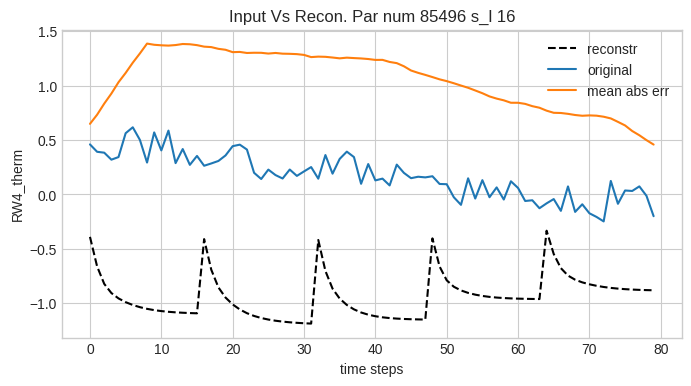

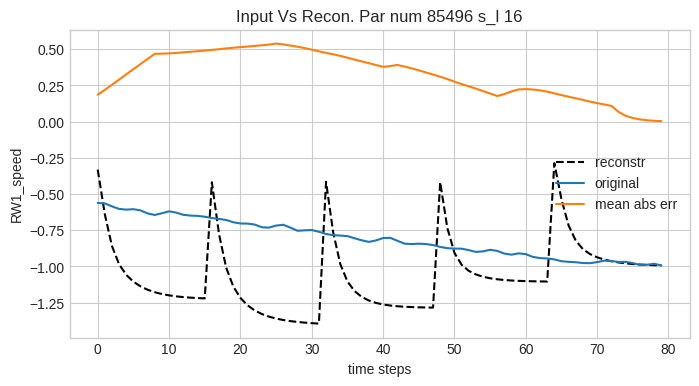

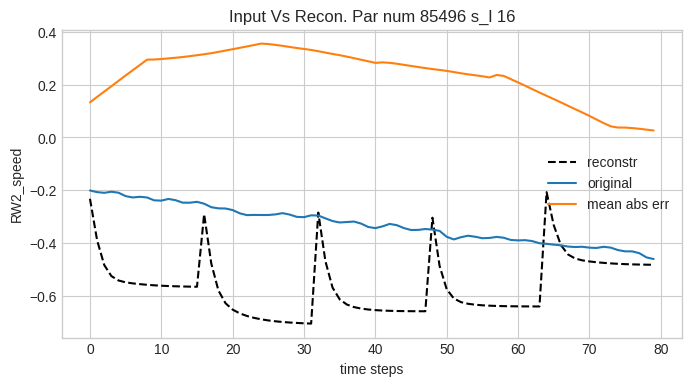

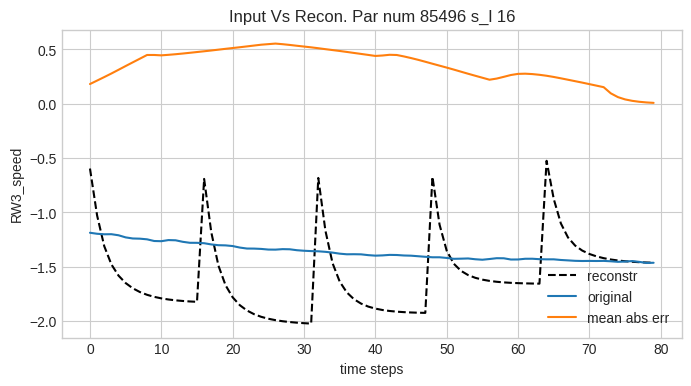

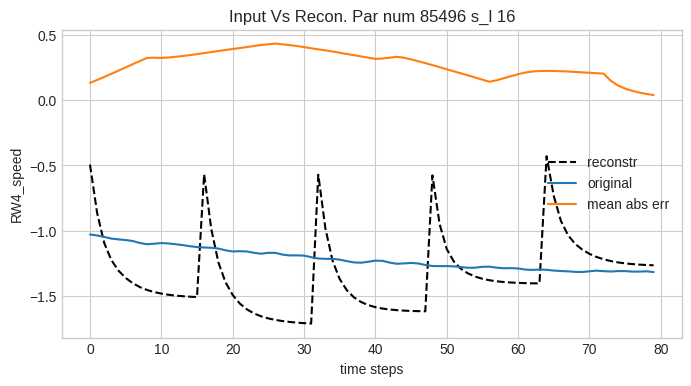

In [27]:
show_results(x, yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,architecture=architecture,save=False)